# STAGATE

In [ ]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",      # 使用 XeLaTeX，如果不需要 LaTeX 公式渲染，可以省略
    'font.family': 'serif',          # 字体设置为衬线字体
    'text.usetex': False,            # 禁用 LaTeX，使用 Matplotlib 内置文字渲染
    'pgf.rcfonts': False,            # 禁用 pgf 的默认字体管理
    'pdf.fonttype': 42,              # 确保字体为 TrueType 格式，可被 Illustrator 编辑
    'ps.fonttype': 42,               # EPS 文件也使用 TrueType 格式
    'figure.dpi': 300,               # 设置图形分辨率
    'savefig.dpi': 300,              # 保存的图形文件分辨率
    'axes.unicode_minus': False,     # 避免负号问题
})

# workdir 
BASE_DIR = Path(r'G:\spatial_data\analysis')
RUN_ID = '20250222_combined_analysis_of_pseudo_HCC3D'

# Load one slide exp
base_path = BASE_DIR / f'{RUN_ID}'
data_path = base_path / "segmented"
typ_path = base_path / "cell_typing"
output_path = base_path / "STAGATE"

## load data

In [ ]:
adata = sc.read_h5ad(typ_path / 'adata.h5ad')
combine_adata_st = sc.read_h5ad(typ_path / 'combine_adata_st.h5ad')

## proprocess of data

In [ ]:
celltyp_dir = Path(r'E:\TMC\.lib_legacy\cell_typing\results\2023.9.28-10.17_PRISM_HCC_3D_Pseudo')

combine_adata_st = sc.read_h5ad(celltyp_dir / 'adata_PRISM_HCC_3D_pseudo_st_category_reordered.h5ad')

# format for later analysis
combine_adata_st.X = sp.csr_matrix(combine_adata_st.X)

combine_adata_st.obs['X'] = combine_adata_st.obsm['spatial3d'][:,0]
combine_adata_st.obs['Y'] = combine_adata_st.obsm['spatial3d'][:,1]
combine_adata_st.obs['Z'] = combine_adata_st.obsm['spatial3d'][:,2]
combine_adata_st.obsm['spatial'] = combine_adata_st.obs.loc[:, ['X', 'Y']].values
combine_adata_st.obs.head()

dataset   layer  n_genes_by_counts  log1p_n_genes_by_counts  \
3   PRISM_HCC  layer0                  7                 2.079442   
6   PRISM_HCC  layer0                 12                 2.564949   
12  PRISM_HCC  layer0                  7                 2.079442   
13  PRISM_HCC  layer0                  4                 1.609438   
15  PRISM_HCC  layer0                  6                 1.945910   

    total_counts  log1p_total_counts  n_genes  n_counts  type leiden  ...  \
3            9.0            2.302585        7       9.0    DC     13  ...   
6           20.0            3.044522       12      20.0  CD4+      0  ...   
12          11.0            2.484907        7      11.0  CD4+      0  ...   
13           8.0            2.197225        4       8.0    DC     29  ...   
15           7.0            2.079442        6       7.0  CD4+      0  ...   

   direction_projection HBV_grade HBV_content HBV_grade_4 HBV_grade_detailed  \
3          23862.042557        -2           0          -2                 -2   
6          23210.293173        -2           0          -2                 -2   
12         23289.167834        -2           0          -2                 -2   
13         24028.020456        -2           0          -2                 -2   
15         24345.904439        -2           0          -2                 -2   

   AFP_content  AFP_grade             X           Y    Z  
3            0         -2  26378.435020  600.279200  0.0  
6            0         -2  25614.760921  670.271470  0.0  
12           0         -2  25682.656401  710.849615  0.0  
13           1          0  26512.902626  702.481852  0.0  
15           0         -2  26846.669260  745.758777  0.0  

[5 rows x 28 columns]

In [ ]:
np.unique(combine_adata_st.obsm['spatial3d'][:,2])

array([   0.        ,   61.53846154,  123.07692308,  184.61538462,
        246.15384615,  307.69230769,  369.23076923,  430.76923077,
        492.30769231,  553.84615385,  615.38461538,  676.92307692,
        738.46153846,  800.        ,  861.53846154,  923.07692308,
        984.61538462, 1046.15384615, 1107.69230769, 1169.23076923])

## training of STAGATE and build graph

In [ ]:
import STAGATE_pyG as STAGATE

In [ ]:
section_order = [f'layer{_}' for _ in range(20)]
STAGATE.Cal_Spatial_Net_3D(combine_adata_st, rad_cutoff_2D=30, rad_cutoff_Zaxis=100, key_section='layer', section_order = section_order, verbose=False)

In [ ]:
combine_adata_st_STAGATE = STAGATE.train_STAGATE(combine_adata_st, hidden_dims=[64, 30])

Size of Input:  (1794158, 30)


100%|██████████| 1000/1000 [1:46:43<00:00,  6.40s/it]


In [ ]:
combine_adata_st_STAGATE.write(celltyp_dir / 'combine_adata_st_STAGATE.h5ad')

In [ ]:
combine_adata_st_STAGATE = sc.read_h5ad(celltyp_dir / 'combine_adata_st_STAGATE.h5ad')

In [ ]:
sc.pp.neighbors(combine_adata_st_STAGATE, n_neighbors=50, use_rep='STAGATE')
sc.tl.umap(combine_adata_st_STAGATE)

In [ ]:
combine_adata_st_STAGATE.write_h5ad(celltyp_dir / 'combine_adata_st_STAGATE.h5ad')

## clustering of ROIs

In [ ]:
import STAGATE

combine_adata_st_STAGATE = sc.read_h5ad(output_path / 'rad_cutoff_250' / 'adata_STAGATE_hid_dim_64_24.h5ad')

# for cluster in range(5,13):
cluster = 9
combine_adata_st_STAGATE = STAGATE.mclust_R(combine_adata_st_STAGATE, used_obsm='STAGATE', num_cluster=cluster)
combine_adata_st_STAGATE.obs.mclust = combine_adata_st_STAGATE.obs.mclust.astype(str)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [ ]:
combine_adata_st_STAGATE.write_h5ad(celltyp_dir / 'combine_adata_st_STAGATE.h5ad')

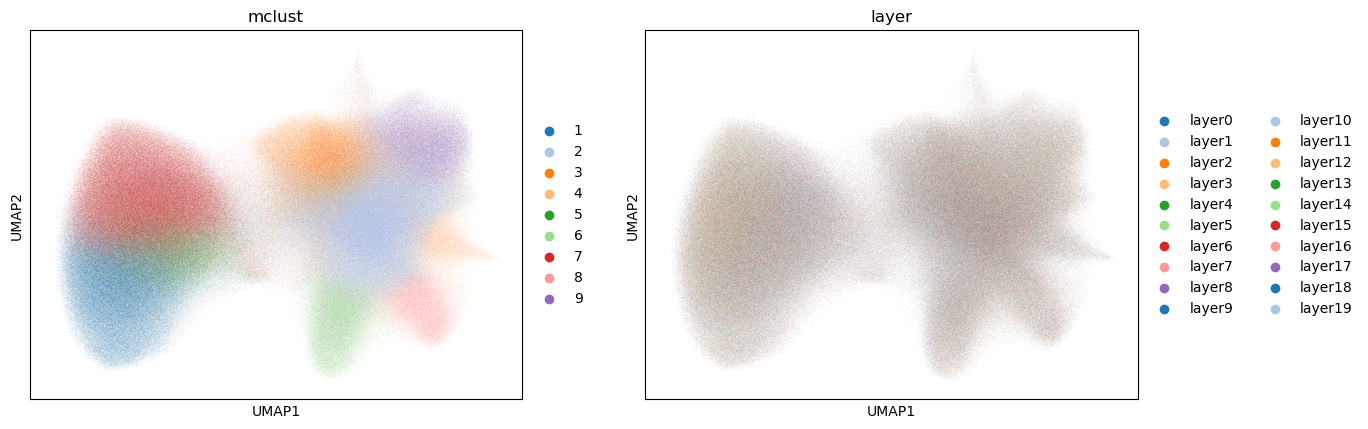

In [ ]:
colors = sns.color_palette('tab20')
print(colors)
sc.pl.umap(combine_adata_st_STAGATE, color=['mclust', 'layer'], palette=colors)

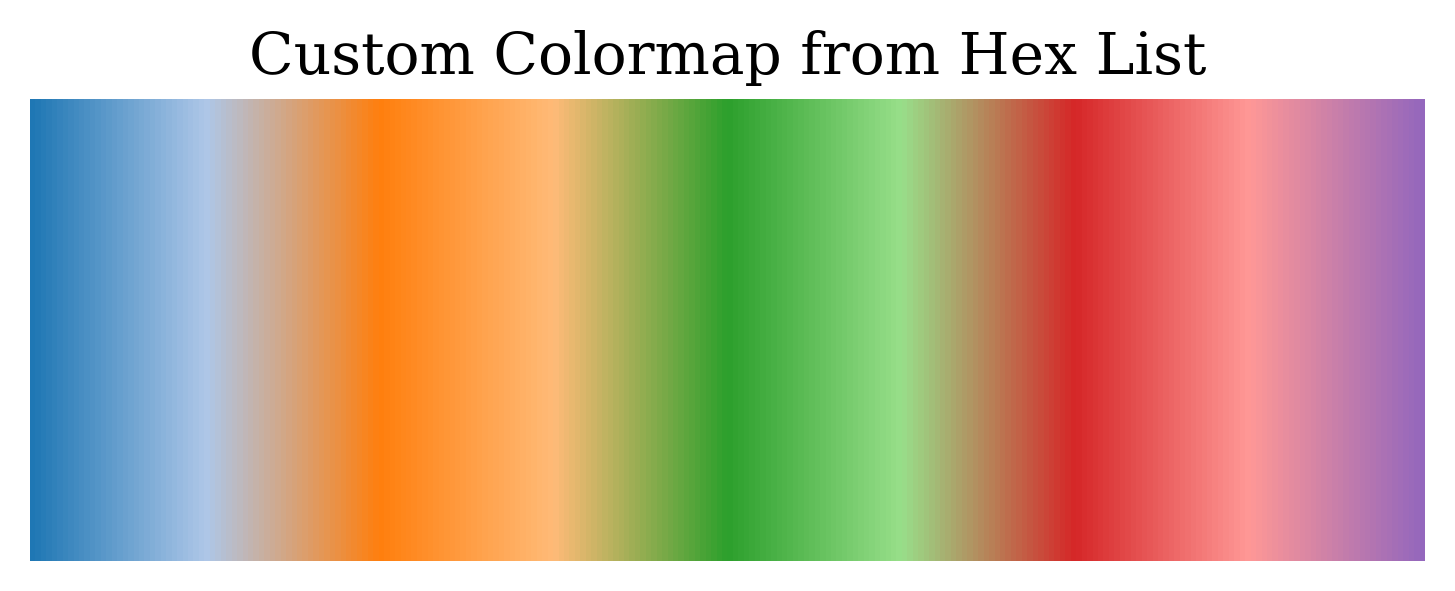

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Your list of hexadecimal color codes
color_list = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', 
    '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd'
]

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", color_list, N=256)

# Function to plot the colormap
def plot_custom_colormap(cmap):
    # Create a gradient image to visualize the colormap
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.set_title('Custom Colormap from Hex List', fontsize=14)
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.axis('off')

    # Show the plot
    plt.show()

# Plot the custom colormap
plot_custom_colormap(custom_cmap)


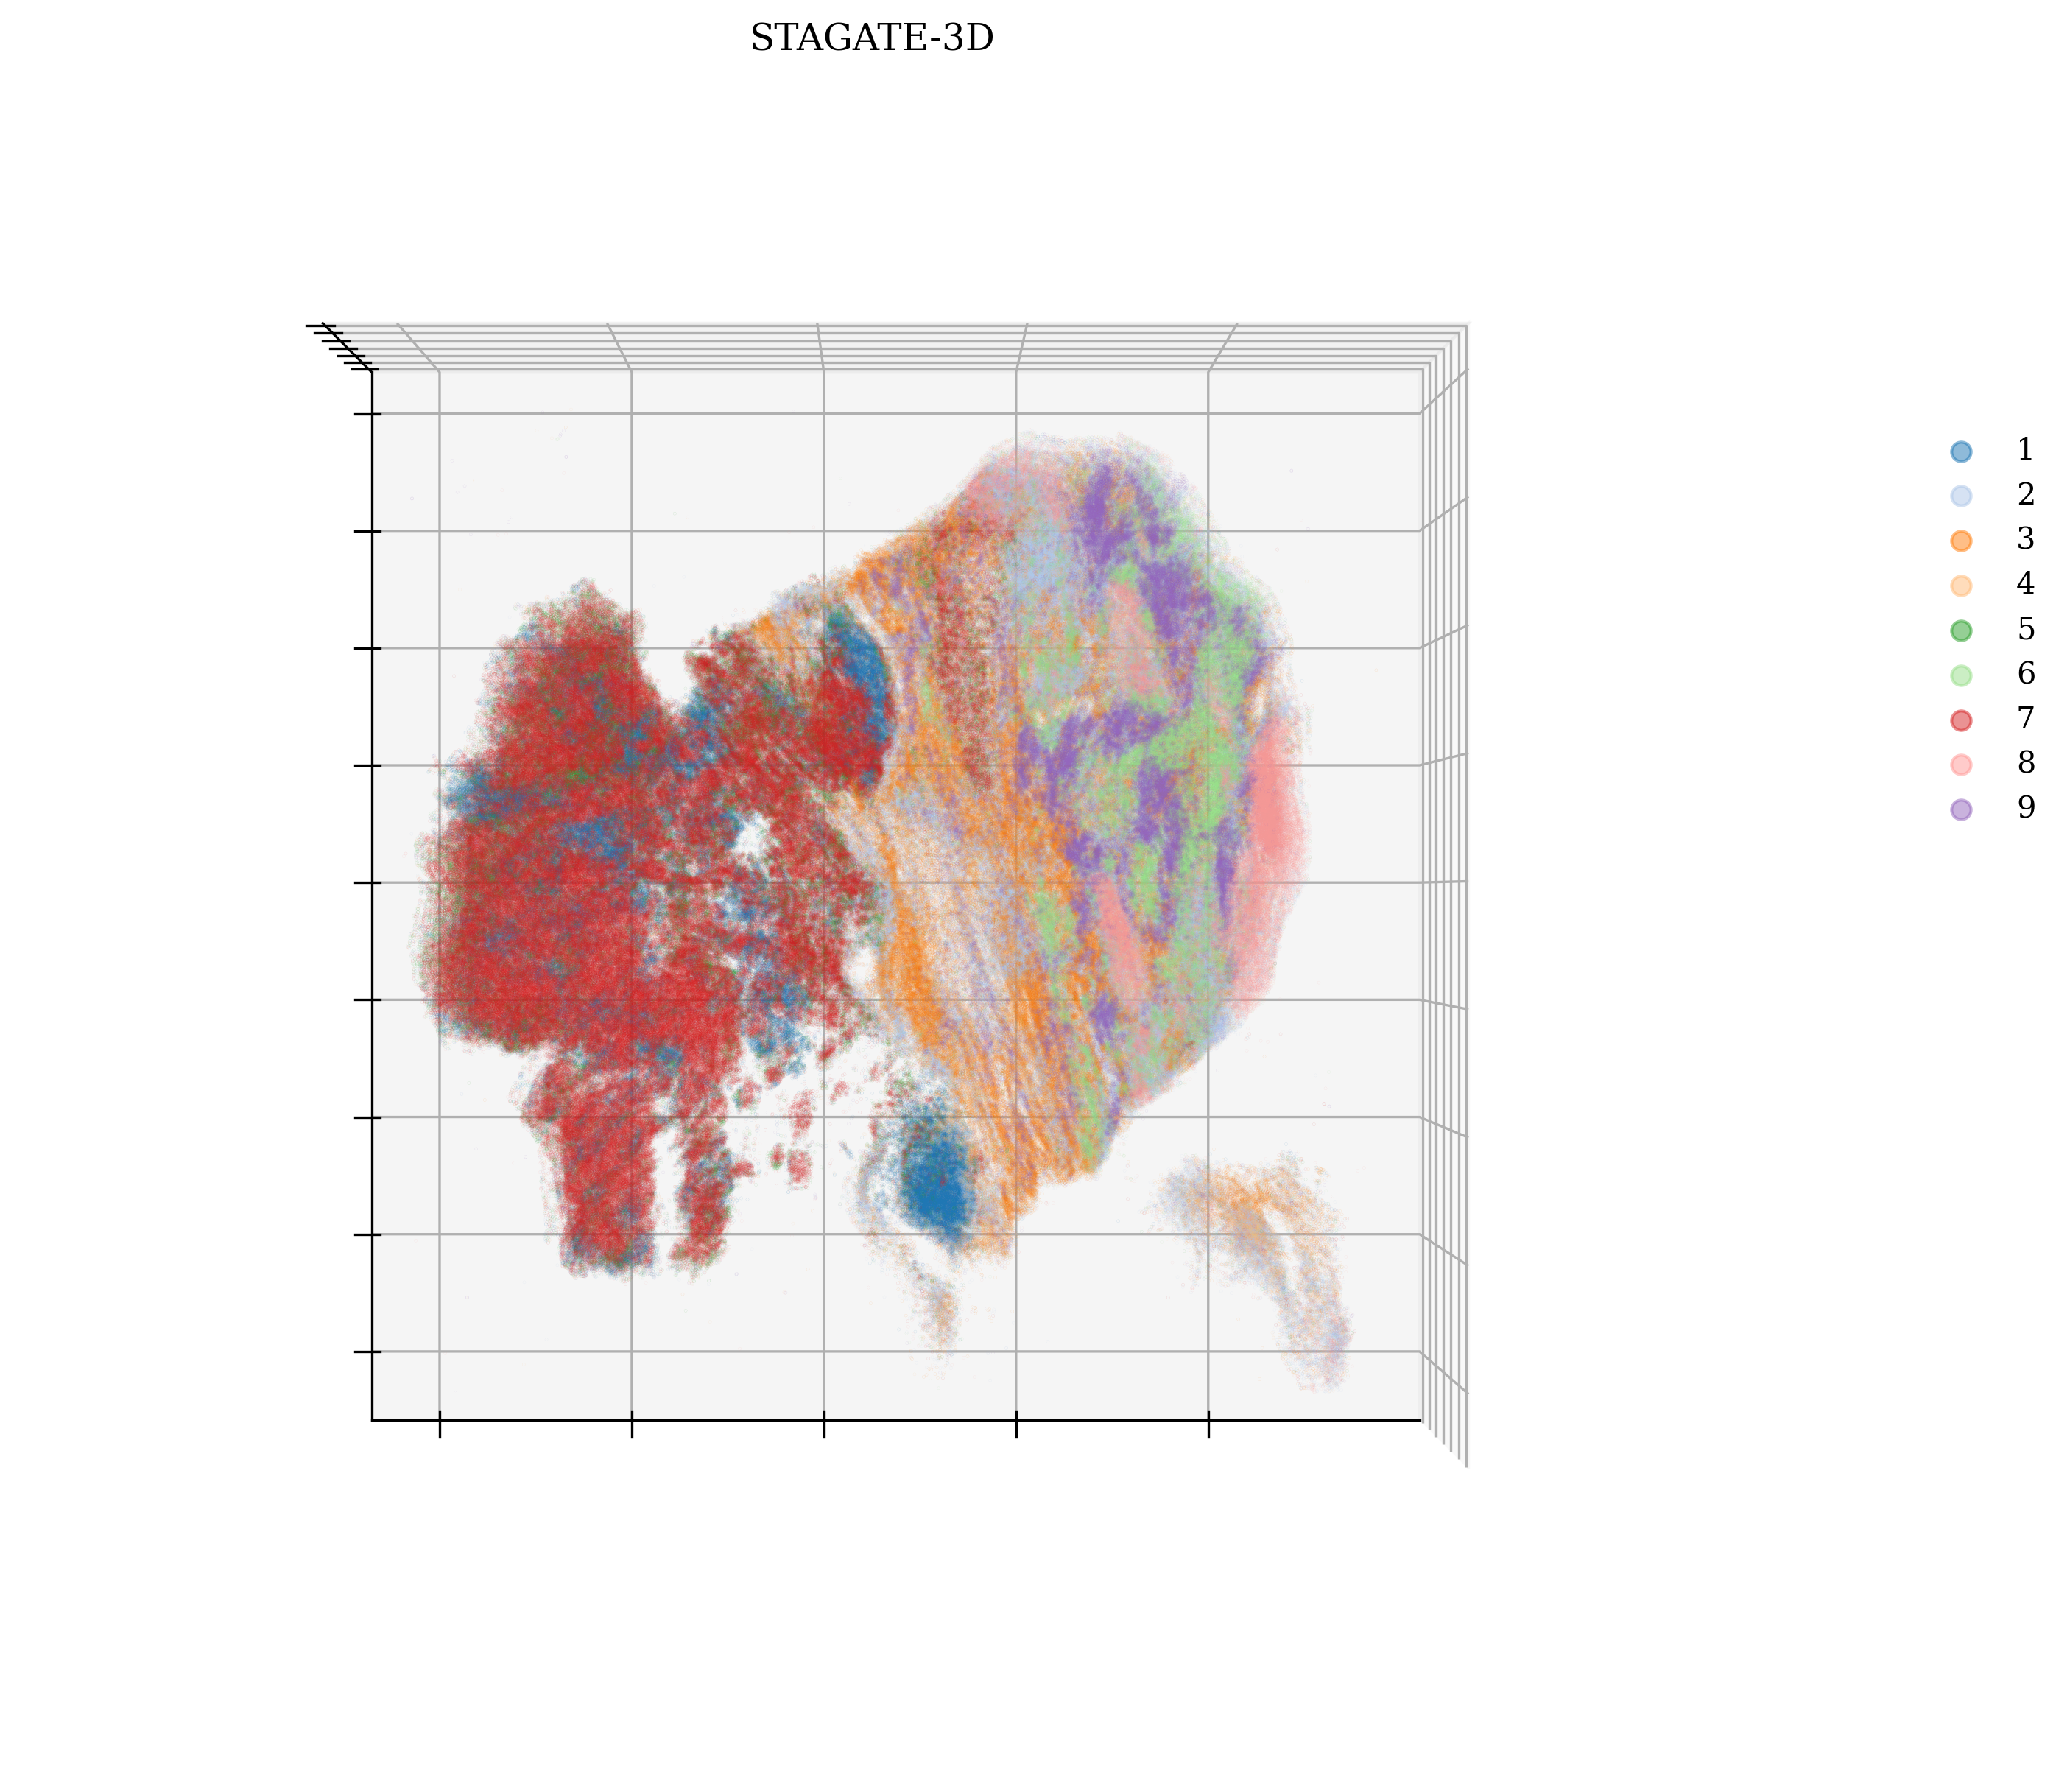

In [ ]:
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

fig = plt.figure(figsize=(10, 10))
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(combine_adata_st_STAGATE.obs['mclust'])):
    temp_Coor = combine_adata_st_STAGATE.obs.loc[combine_adata_st_STAGATE.obs['mclust']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=combine_adata_st_STAGATE.uns['mclust_colors'][it], s=0.001, alpha=0.5, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1.2,0.8), markerscale=200, frameon=False)
plt.title('STAGATE-3D')

# ax1.elev = -90
# ax1.azim = 90

ax1.elev = 90
ax1.azim = -90

plt.show()

In [ ]:
mclust_dict = {
    'Tumor':[1,2,],
    'Liver':[4,5,],
    'Fiber':[3,4,],
    'Ductal':[],
    'Endothelial':[],
}
combine_adata_st_STAGATE = re_num_leiden(combine_adata_st_STAGATE, mclust_dict, 
                                         in_leiden='mclust', out_leiden='mclust_renum', 
                                         out_type='mclust_name')

In [ ]:
combine_adata_st_STAGATE.write_h5ad(celltyp_dir / 'combine_adata_st_STAGATE.h5ad')